# ENA Factor Analysis — Short Thesis (> $1B MC Universe)

This notebook builds a Fama–French style factor model over large-cap crypto assets and uses it to analyze **Ethena (ENA)** for a short thesis in the Franklin Templeton × Midwest Blockchain Conference research competition.

**High-level steps:**

1. Use the **Artemis SDK** to pull fundamental & price data for all assets.
2. Construct a **weekly panel** (2022–present) with:
   - Market cap (`mc`)
   - Market cap to fees ratio (`mc_fees_ratio`)
   - Price and weekly returns
3. Define the **> $1B circulating market cap universe** and exclude stablecoins/derivatives.
4. Build time-series factors:
   - **Market factor**: MC-weighted large-cap index (top 20 by MC)
   - **SMB**: Small minus Big (within > $1B)
   - **MOM**: Momentum (top vs bottom 30% by 12-week return)
   - **VALUE**: Value (low vs high MC/fees ratio)
5. Compute **ENA weekly returns** and run regressions:
   - ENA raw/log returns vs Market + SMB + MOM + VALUE.
6. Summarize and visualize ENA’s factor exposures as evidence for a short thesis.


In [1]:
import os
from dotenv import load_dotenv

# Try to load from .env file, but don't fail if it doesn't exist or is malformed
try:
    load_dotenv()
except Exception as e:
    print(f"Warning: Could not load .env file: {e}")
    print("Continuing with environment variables...")

# Store Artemis API key in .env file or environment variables
API_KEY = os.getenv("ARTEMIS_API_KEY")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from artemis import Artemis

WEEKS_PER_YEAR = 52

def annualize_from_weekly_raw(alpha_week, se_week):
    """
    For raw (simple) weekly returns:
    - Approximate annualized alpha as 52 * alpha_week
    - Maintain t-statistics (scale alpha and SE by same factor).
    """
    alpha_ann = WEEKS_PER_YEAR * alpha_week
    se_ann = WEEKS_PER_YEAR * se_week
    t = alpha_week / se_week if se_week != 0 else np.nan
    return alpha_ann, se_ann, t

def annualize_from_weekly_log(alpha_week_log, se_week_log):
    """
    For log weekly returns:
    - Annual log alpha = 52 * alpha_week_log
    - Convert to simple percentage alpha via exp(alpha_ann_log) - 1
    - t-stat invariant under scaling.
    """
    alpha_ann_log = WEEKS_PER_YEAR * alpha_week_log
    alpha_ann_simple = np.exp(alpha_ann_log) - 1
    se_ann_log = WEEKS_PER_YEAR * se_week_log
    t = alpha_week_log / se_week_log if se_week_log != 0 else np.nan
    return alpha_ann_log, alpha_ann_simple, se_ann_log, t


plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

# -----------------------------------
# Artemis API key
# -----------------------------------
# Recommended: set as environment variable before running:
#   export ARTEMIS_API_KEY="your_key_here"
#
# For convenience in this notebook, we allow direct assignment as fallback.

client = Artemis(api_key=API_KEY)

# Analysis window
START_DATE = "2022-01-01"   # factor & universe start
END_DATE   = "2025-11-21"           # None = latest available; or e.g. "2025-11-20"

MC_THRESHOLD = 1_000_000_000  # > $1B universe
MIN_CROSS_SECTION = 20        # minimum number of >$1B assets to build style factors
TOP_N_MARKET = 20          # top N by MC for MARKET
MOM_LOOKBACK_WEEKS = 12       # 12-week momentum with 1-week skip


## 1. Retrieve asset metrics from Artemis

We:

1. Get the full asset symbol list from Artemis.
2. Pull **price**, **market cap (`mc`)**, and **market cap to fees ratio (`mc_fees_ratio`)**.
3. Build a long panel and pivot to have metrics as columns:  
   `index = (date, asset)` → columns = `mc`, `mc_fees_ratio`, `price`.


In [3]:
import time

# 1. List all asset symbols
all_assets = client.asset.list_asset_symbols()
symbols = [asset["symbol"] for asset in all_assets["assets"]]

if END_DATE is None:
    from datetime import datetime
    END_DATE = datetime.utcnow().strftime("%Y-%m-%d")

metrics = "price,mc,mc_fees_ratio"

# smaller batch size to be kinder to the API
symbol_batch_size = 50

full_data_dict = {}
failed_batches = []

for i in range(0, len(symbols), symbol_batch_size):
    batch = symbols[i:i + symbol_batch_size]
    print(f"Fetching metrics for batch {i//symbol_batch_size + 1} / {len(symbols)//symbol_batch_size + 1} "
          f"({len(batch)} symbols)...")

    success = False
    for attempt in range(3):  # up to 3 retries
        try:
            metrics_for_asset = client.fetch_metrics(
                metric_names=metrics,
                symbols=batch,
                start_date=START_DATE,
                end_date=END_DATE,
            )
            full_data_dict.update(metrics_for_asset.data.symbols)
            success = True
            # short sleep between successful calls to avoid hammering the API
            time.sleep(0.5)
            break
        except Exception as e:
            print(f"  Attempt {attempt+1} failed for this batch: {e}")
            # longer sleep before retrying this batch
            time.sleep(2)

    if not success:
        print("  Failed all retries for this batch. Skipping these symbols.")
        failed_batches.extend(batch)

print(f"\nTotal symbols fetched successfully: {len(full_data_dict)}")
print(f"Total symbols failed (skipped): {len(failed_batches)}")

# ---- Flatten into a DataFrame exactly as before ----
records = []

for asset, metric_dict in full_data_dict.items():
    for metric, values in metric_dict.items():
        for item in values:
            if isinstance(item, dict):
                records.append({
                    "date": item["date"],
                    "asset": asset,
                    "metric": metric,
                    "value": item["val"],
                })

raw_df = pd.DataFrame(records)

# Pivot: (date, asset) as index, metrics as columns
pivoted_df = raw_df.pivot(
    index=["date", "asset"],
    columns="metric",
    values="value",
).reset_index()

pivoted_df.columns.name = None
pivoted_df["date"] = pd.to_datetime(pivoted_df["date"])
pivoted_df = pivoted_df.set_index("date").sort_index()

pivoted_df.head()


Fetching metrics for batch 1 / 10 (50 symbols)...
Fetching metrics for batch 2 / 10 (50 symbols)...
Fetching metrics for batch 3 / 10 (50 symbols)...
Fetching metrics for batch 4 / 10 (50 symbols)...
Fetching metrics for batch 5 / 10 (50 symbols)...
Fetching metrics for batch 6 / 10 (50 symbols)...
Fetching metrics for batch 7 / 10 (50 symbols)...
Fetching metrics for batch 8 / 10 (50 symbols)...
Fetching metrics for batch 9 / 10 (50 symbols)...
Fetching metrics for batch 10 / 10 (49 symbols)...

Total symbols fetched successfully: 499
Total symbols failed (skipped): 0


,asset,mc,mc_fees_ratio,price
date,,,,
2022-01-01,ATH,NaN,NaN,NaN
2022-01-01,M,NaN,NaN,NaN
2022-01-01,aave,3.563670e+09,14.181055,266.532032
2022-01-01,aca,NaN,NaN,NaN
2022-01-01,acx,NaN,NaN,NaN


## 2. Weekly resampling and feature engineering

We:

- Resample to **weekly frequency** per asset (last observation of the week).
- Compute:
  - Weekly % price change (`price_weekly_pct_change`)
  - Prior-week market cap (`mc_t_minus_1`)
  - Prior-week value proxy (`mc_fees_ratio_t_minus_1`)
  - 12-week momentum (`price_12wk_pct_change`), with a 1-week skip to mitigate short-term mean reversion.
- Drop stablecoins from the universe (symbols containing 'usd').


In [4]:
# Weekly resample by asset
weekly_df = pivoted_df.groupby("asset").resample("W").agg({
    "mc": "last",
    "mc_fees_ratio": "last",
    "price": "last",
}).reset_index()

weekly_df = weekly_df.sort_values(["date", "asset"])

# Weekly returns
weekly_df["price_weekly_pct_change"] = (
    weekly_df.groupby("asset")["price"].pct_change()
)

# Lagged metrics (t-1)
weekly_df["mc_t_minus_1"] = (
    weekly_df.groupby("asset")["mc"].shift(1)
)
weekly_df["mc_fees_ratio_t_minus_1"] = (
    weekly_df.groupby("asset")["mc_fees_ratio"].shift(1)
)

# 12-week momentum with 1-week skip:
# momentum at time t = price(t-1)/price(t-13) - 1
weekly_df["price_12wk_pct_change"] = (
    weekly_df.groupby("asset")["price"]
    .transform(lambda x: x.shift(1) / x.shift(1 + MOM_LOOKBACK_WEEKS) - 1)
)

# Remove stablecoins (crude filter by 'usd' in symbol)
weekly_df = weekly_df[~weekly_df["asset"].str.contains("usd", case=False, na=False)]

# Keep 2022+ only (safety, in case Artemis gave earlier data)
weekly_df = weekly_df[weekly_df["date"] >= pd.to_datetime(START_DATE)]

# Drop assets that have no mc AND no price across the entire window
valid_assets = weekly_df.groupby("asset")[["mc", "price"]].apply(
    lambda g: g.notna().any().any()
)
weekly_df = weekly_df[weekly_df["asset"].isin(valid_assets[valid_assets].index)]

# Drop leading rows before first valid mc/price for each asset
def drop_leading_all_nan(group):
    mask_valid = group[["mc", "price"]].notna().any(axis=1)
    if not mask_valid.any():
        return pd.DataFrame(columns=group.columns)
    first_valid_idx = mask_valid.idxmax()
    return group.loc[first_valid_idx:]

weekly_df = (
    weekly_df
    .sort_values(["asset", "date"])
    .groupby("asset", group_keys=False)
    .apply(drop_leading_all_nan)
    .reset_index(drop=True)
)

weekly_df.head()


weekly_df.head()


/var/folders/w8/x1rpwfh944lbn_nnxkcqkpdm0000gn/T/ipykernel_18689/455604950.py:12: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_df.groupby("asset")["price"].pct_change()
/var/folders/w8/x1rpwfh944lbn_nnxkcqkpdm0000gn/T/ipykernel_18689/455604950.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(drop_leading_all_nan)


,asset,date,mc,mc_fees_ratio,price,price_weekly_pct_change,mc_t_minus_1,mc_fees_ratio_t_minus_1,price_12wk_pct_change
0,ATH,2024-06-16,2.476514e+08,NaN,0.065564,NaN,NaN,NaN,NaN
1,ATH,2024-06-23,2.592730e+08,NaN,0.068642,0.046946,2.476514e+08,NaN,NaN
2,ATH,2024-06-30,2.621057e+08,NaN,0.069333,0.010063,2.592730e+08,NaN,NaN
3,ATH,2024-07-07,2.491405e+08,NaN,0.066000,-0.048070,2.621057e+08,NaN,NaN
4,ATH,2024-07-14,2.810513e+08,NaN,0.074392,0.127146,2.491405e+08,NaN,NaN


## 3. Construct Fama–French style factors

For each week:

- Define the **large-cap universe** as assets with `mc_t_minus_1 >= $1B`.
- Require at least **20 assets** in this universe to build style factors.
- Compute:

1. **Market factor** (`market`):  
   - MC-weighted portfolio of the **top 20 assets by `mc`** (within > $1B universe).
2. **SMB** (`smb`):  
   - Split >$1B universe at median `mc_t_minus_1`.
   - `SMB = return_small - return_big`, where each side is MC-weighted.
3. **MOM** (`mom`):  
   - Within >$1B universe, take top 30% vs bottom 30% by `price_12wk_pct_change`.
   - MC-weighted long–short.
4. **VALUE** (`value`):  
   - Within >$1B universe, take lowest 30% vs highest 30% by `mc_fees_ratio_t_minus_1`.
   - MC-weighted long–short.

If fewer than 20 assets qualify in a given week, we skip factor construction for that week.


In [5]:
factor_returns = []

for date, group in weekly_df.groupby("date"):
    # Use only assets with valid lagged MC and weekly return
    group = group.copy()
    group_1b = group[group["mc_t_minus_1"] >= MC_THRESHOLD].dropna(
        subset=["mc_t_minus_1", "price_weekly_pct_change"]
    )

    if len(group_1b) < MIN_CROSS_SECTION:
        # Not enough large caps to build stable factors
        continue

    result = {"date": date}

    # Helper for MC-weighted average return
    def mc_weighted_return(df, mc_col="mc_t_minus_1", ret_col="price_weekly_pct_change"):
        w = df[mc_col]
        r = df[ret_col]
        if w.sum() == 0:
            return np.nan
        return (w * r).sum() / w.sum()

    # market: top N by current MC (not lagged)
    bench_group = group_1b.dropna(subset=["mc", "price_weekly_pct_change"])
    if not bench_group.empty:
        topN = bench_group.nlargest(TOP_N_MARKET, "mc")
        result["market"] = mc_weighted_return(topN, mc_col="mc")

    # SMB: Small minus Big (by mc_t_minus_1)
    smb_group = group_1b.dropna(subset=["mc_t_minus_1", "price_weekly_pct_change"])
    if not smb_group.empty:
        mc_median = smb_group["mc_t_minus_1"].median()
        small = smb_group[smb_group["mc_t_minus_1"] <= mc_median]
        big   = smb_group[smb_group["mc_t_minus_1"] > mc_median]
        if len(small) > 0 and len(big) > 0:
            result["smb"] = mc_weighted_return(small) - mc_weighted_return(big)

    # MOM: Top vs bottom 30% by 12-week momentum
    mom_group = group_1b.dropna(
        subset=["mc_t_minus_1", "price_12wk_pct_change", "price_weekly_pct_change"]
    )
    if len(mom_group) >= MIN_CROSS_SECTION:
        k = int(len(mom_group) * 0.3)
        if k >= 1:
            top_mom = mom_group.nlargest(k, "price_12wk_pct_change")
            bottom_mom = mom_group.nsmallest(k, "price_12wk_pct_change")
            result["mom"] = mc_weighted_return(top_mom) - mc_weighted_return(bottom_mom)

    # VALUE: Low vs high mc_fees_ratio (value vs expensive)
    value_group = group_1b.dropna(
        subset=["mc_t_minus_1", "price_weekly_pct_change", "mc_fees_ratio_t_minus_1"]
    )
    if len(value_group) >= MIN_CROSS_SECTION:
        k = int(len(value_group) * 0.3)
        if k >= 1:
            low_mult  = value_group.nsmallest(k, "mc_fees_ratio_t_minus_1")
            high_mult = value_group.nlargest(k, "mc_fees_ratio_t_minus_1")
            result["value"] = mc_weighted_return(low_mult) - mc_weighted_return(high_mult)

    # Keep only if we computed at least the market
    if "market" in result:
        factor_returns.append(result)

factor_returns_df = pd.DataFrame(factor_returns).sort_values("date").reset_index(drop=True)
factor_returns_df.head()


,date,market,smb,value,mom
0,2022-01-09,-0.144133,0.015681,-0.060644,NaN
1,2022-01-16,0.048506,0.013278,0.031461,NaN
2,2022-01-23,-0.131781,-0.115215,-0.083849,NaN
3,2022-01-30,0.029340,0.005409,-0.014207,NaN
4,2022-02-06,0.120684,0.054384,0.048439,NaN


## 4. ENA weekly returns

We extract ENA's weekly price series from the same `weekly_df` and compute raw and log returns.

> **Note:** Artemis symbols are usually lowercase (e.g., `ena`), but double-check in your data with `weekly_df['asset'].unique()`.


In [25]:
# Inspect a few asset names to confirm ENA symbol
weekly_df["asset"].drop_duplicates().sort_values()

# Assume symbol is 'ena' (change here if needed)
ENA_SYMBOL = "ena"

ena_df = weekly_df[weekly_df["asset"] == ENA_SYMBOL].copy()
ena_df = ena_df.sort_values("date")

# Raw and log returns, aligned with weekly factor frequency
ena_df["ENA_price"] = ena_df["price"].astype(float)
ena_df["ENA_raw_ret"] = ena_df["ENA_price"].pct_change()
ena_df["ENA_log_ret"] = np.log(ena_df["ENA_price"]).diff()

ena_df[["date", "ENA_price", "ENA_raw_ret", "ENA_log_ret"]].tail(5)


,date,ENA_price,ENA_raw_ret,ENA_log_ret
14349,2025-10-26,0.509746,0.057080,0.055510
14350,2025-11-02,0.373956,-0.266387,-0.309774
14351,2025-11-09,0.326602,-0.126630,-0.135396
14352,2025-11-16,0.275191,-0.157411,-0.171276
14353,2025-11-23,0.236969,-0.138895,-0.149539


## 5. Factor regressions: ENA vs Market, SMB, MOM, VALUE

We merge ENA’s weekly returns with our factor return series on the date index, then run OLS regressions:

1. **ENA raw returns** on `[market, smb, mom, value]`
2. **ENA log returns** on `[market, smb, mom, value]`

Formally:


$r^{ENA}_t = \alpha + \beta_{MKT} \cdot r^{MKT}_t + \beta_{SMB} \cdot SMB_t + \beta_{MOM} \cdot MOM_t + \beta_{VALUE} \cdot VALUE_t + \varepsilon_t$





In [7]:
# Merge on date
fact = factor_returns_df.set_index("date")
ena = ena_df.set_index("date")

merged = ena[["ENA_raw_ret", "ENA_log_ret"]].join(
    fact[["market", "smb", "mom", "value"]],
    how="inner",
)

# Drop missing values
reg_df = merged.dropna()
reg_df.head()

# Design matrix (factors + intercept)
X = sm.add_constant(reg_df[["market", "smb", "mom", "value"]])

# 1) Raw returns regression
y_raw = reg_df["ENA_raw_ret"]
model_raw = sm.OLS(y_raw, X).fit()

# 2) Log returns regression
y_log = reg_df["ENA_log_ret"]
model_log = sm.OLS(y_log, X).fit()

print("=== ENA RAW RETURNS ~ market + SMB + MOM + VALUE ===")
print(model_raw.summary())

print("\n=== ENA LOG RETURNS ~ market + SMB + MOM + VALUE ===")
print(model_log.summary())


=== ENA RAW RETURNS ~ market + SMB + MOM + VALUE ===
                            OLS Regression Results                            
Dep. Variable:            ENA_raw_ret   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     31.51
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           9.35e-16
Time:                        21:37:40   Log-Likelihood:                 56.528
No. Observations:                  85   AIC:                            -103.1
Df Residuals:                      80   BIC:                            -90.84
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

### Full Four-Factor summary for ENA

We extract alpha, betas, and R² for both specifications, which will feed directly into the written short thesis.


In [8]:
def compact_summary(m):
    params = m.params
    alpha = params["const"]
    betas = params.drop("const")
    r2 = m.rsquared
    return alpha, betas, r2

alpha_raw, betas_raw, r2_raw = compact_summary(model_raw)
alpha_log, betas_log, r2_log = compact_summary(model_log)

print("=== Raw returns ===")
print(f"alpha: {alpha_raw:.4e}")
print(betas_raw)
print(f"R^2: {r2_raw:.3f}")

print("\n=== Log returns ===")
print(f"alpha: {alpha_log:.4e}")
print(betas_log)
print(f"R^2: {r2_log:.3f}")


=== Raw returns ===
alpha: -3.3221e-04
market    1.655756
smb       1.010093
mom      -0.059855
value     0.257879
dtype: float64
R^2: 0.612

=== Log returns ===
alpha: -1.9383e-02
market    1.628679
smb       0.967056
mom      -0.058750
value     0.311017
dtype: float64
R^2: 0.623


## 6. HAC-robust (Newey–West) standard errors

Our weekly regressions may exhibit **serial correlation** and **heteroskedasticity** in the residuals, which makes the usual OLS standard errors potentially misleading. To address this, we re-estimate the log-return factor models using **Newey–West (HAC) standard errors**.

- We keep the **same coefficients** (point estimates) as OLS, but adjust the **covariance matrix** to be robust to:
  - heteroskedasticity; and  
  - autocorrelation up to a chosen lag `L`.

Because we work with **weekly data**, a natural choice is `L = 4` (about one month of weekly lags). In the next cell, we:

1. Fit the **4-factor log** model (market, SMB, momentum, value) on the training sample with HAC SEs;
2. Fit the **2-factor log** model (market, SMB) with HAC SEs; and
3. Inspect how the **t-stats on alpha and factor loadings** change relative to vanilla OLS.


In [9]:
# 6. HAC-robust standard errors for weekly factor models

four_factors = ["market", "smb", "mom", "value"]
two_factors = ["market", "smb"]

# Reuse train/test split if already created; otherwise define an 80/20 split.
reg_df = reg_df.sort_index()
if "train_df" not in globals() or "test_df" not in globals():
    n = len(reg_df)
    train_size = int(0.8 * n)
    train_df = reg_df.iloc[:train_size].copy()
    test_df = reg_df.iloc[train_size:].copy()

def fit_ols_hac(dep_col, factor_cols, df, maxlags=4):
    """
    Fit OLS with Newey–West (HAC) standard errors.
    The point estimates are the same as vanilla OLS; only the SEs change.
    """
    X = sm.add_constant(df[factor_cols])
    y = df[dep_col]
    model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
    return model

# Log-return specifications as our main economic model
hac_4_log = fit_ols_hac("ENA_log_ret", four_factors, train_df, maxlags=4)
hac_2_log = fit_ols_hac("ENA_log_ret", two_factors, train_df, maxlags=4)

print("=== 4-factor log model with Newey–West SEs (maxlags=4) ===")
print(hac_4_log.summary())

print("\n=== 2-factor log model with Newey–West SEs (maxlags=4) ===")
print(hac_2_log.summary())


=== 4-factor log model with Newey–West SEs (maxlags=4) ===
                            OLS Regression Results                            
Dep. Variable:            ENA_log_ret   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     42.32
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           3.39e-17
Time:                        21:38:09   Log-Likelihood:                 48.375
No. Observations:                  68   AIC:                            -86.75
Df Residuals:                      63   BIC:                            -75.65
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

## 7. Rolling (Expanding-Window) Market & SMB Betas

To understand how ENA’s factor exposures evolve through time, we run an **expanding-window regression**.

For each week \( t \), we estimate:

$r^{ENA}_s = \alpha_t + \beta^{MKT}_t \cdot MKT_s + \beta^{SMB}_t \cdot SMB_s + \varepsilon_s,
\quad s \le t,$

using **all available historical data up to and including week \( t \)**.

We then collect the rolling estimates $\alpha_t, \beta^{MKT}_t, \beta^{SMB}_t $ and visualize how ENA’s betas change over time.


In [10]:
# 7. Rolling (expanding-window) regression: ENA log returns ~ market + SMB

min_obs = 4  # require ~1 month of data before trusting estimates

dates = reg_df.index
beta_mkt_list = []
beta_smb_list = []
alpha_list = []

for end_idx in range(len(reg_df)):
    # expanding window: everything up to and including this index
    if end_idx + 1 < min_obs:
        alpha_list.append(np.nan)
        beta_mkt_list.append(np.nan)
        beta_smb_list.append(np.nan)
        continue
    
    window = reg_df.iloc[: end_idx + 1]
    X_win = sm.add_constant(window[["market", "smb"]])
    y_win = window["ENA_log_ret"]

    res = sm.OLS(y_win, X_win).fit()

    alpha_list.append(res.params["const"])
    beta_mkt_list.append(res.params["market"])
    beta_smb_list.append(res.params["smb"])

rolling_betas = pd.DataFrame(
    {
        "alpha": alpha_list,
        "beta_mkt": beta_mkt_list,
        "beta_smb": beta_smb_list,
    },
    index=dates,
)

rolling_betas.tail()


,alpha,beta_mkt,beta_smb
date,,,
2025-10-26,-0.017586,1.635061,1.057909
2025-11-02,-0.020675,1.671317,1.041955
2025-11-09,-0.021977,1.700158,1.010375
2025-11-16,-0.021772,1.695219,1.013804
2025-11-23,-0.021043,1.677740,1.024793


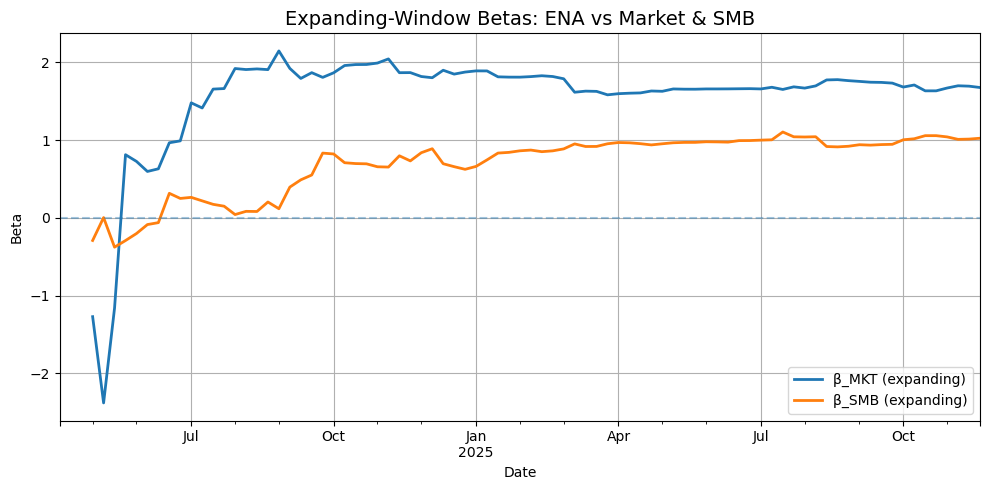

In [22]:
plt.figure(figsize=(10, 5))

rolling_betas["beta_mkt"].plot(label="β_MKT (expanding)", linewidth=2)
rolling_betas["beta_smb"].plot(label="β_SMB (expanding)", linewidth=2)

plt.axhline(0, linestyle="--", alpha=0.4)
plt.title("Expanding-Window Betas: ENA vs Market & SMB", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.tight_layout()
plt.show()


## 8. One-Week-Ahead Forecasts Using Rolling Betas

Now we use the time-varying betas to generate **pseudo-out-of-sample weekly forecasts**.

At time  t , we:

1. Use $\alpha_t, \beta^{MKT}_t, \beta^{SMB}_t$ estimated with data up to t 
2. Observe next week’s factor returns $MKT_{t+1}, SMB_{t+1}$
3. Forecast ENA's log return:

$\widehat{r}^{ENA}_{t+1}= \alpha_t+ \beta^{MKT}_t \cdot MKT_{t+1} + \beta^{SMB}_t \cdot SMB_{t+1}.$

We compare these forecasts to realized ENA returns and compute the correlation.


In [12]:
# Build 1-week-ahead forecasts via rolling betas

# factor returns at t+1 (from perspective of time t)
factors_next = reg_df[["market", "smb"]].shift(-1)

# realized ENA log return at t+1
ena_log_next = reg_df["ENA_log_ret"].shift(-1)

alpha_t = rolling_betas["alpha"]
beta_mkt_t = rolling_betas["beta_mkt"]
beta_smb_t = rolling_betas["beta_smb"]

forecast_log_next = (
    alpha_t
    + beta_mkt_t * factors_next["market"]
    + beta_smb_t * factors_next["smb"]
)

forecast_df = pd.DataFrame(
    {
        "realized_log_ret_next": ena_log_next,
        "forecast_log_ret_next": forecast_log_next,
    },
    index=reg_df.index,
).dropna()

forecast_df.tail()


,realized_log_ret_next,forecast_log_ret_next
date,,
2025-10-19,0.055510,0.054888
2025-10-26,-0.309774,-0.097394
2025-11-02,-0.135396,-0.070672
2025-11-09,-0.171276,-0.182975
2025-11-16,-0.149539,-0.194365


Correlation between 1w-ahead forecasts and realized ENA log returns: 0.7425311294918399


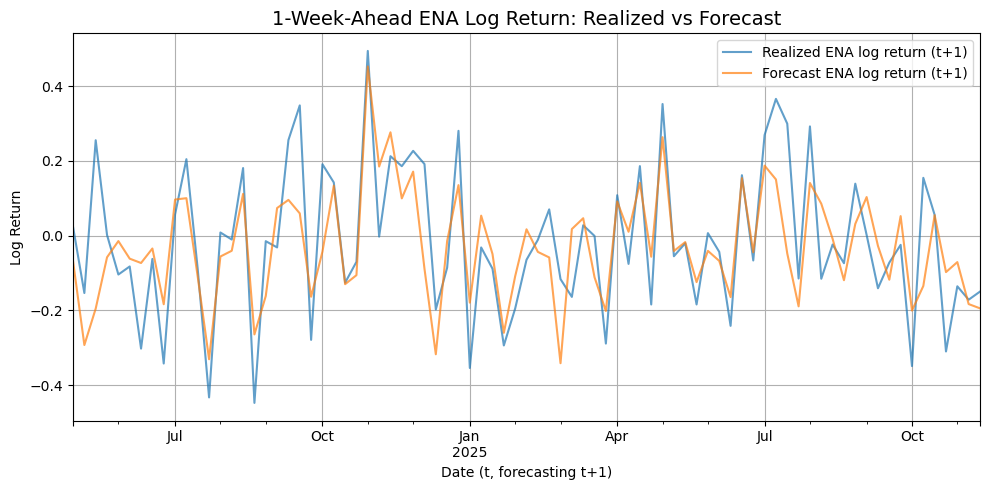

In [13]:
# Correlation between forecasts and realized ENA log returns
corr = forecast_df["realized_log_ret_next"].corr(forecast_df["forecast_log_ret_next"])
print("Correlation between 1w-ahead forecasts and realized ENA log returns:", corr)

# Plot realized vs forecast
plt.figure(figsize=(10, 5))

forecast_df["realized_log_ret_next"].plot(label="Realized ENA log return (t+1)", alpha=0.7)
forecast_df["forecast_log_ret_next"].plot(label="Forecast ENA log return (t+1)", alpha=0.7)

plt.title("1-Week-Ahead ENA Log Return: Realized vs Forecast", fontsize=14)
plt.xlabel("Date (t, forecasting t+1)")
plt.ylabel("Log Return")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
# -------------------------------------------------------------
# Rolling-window (fixed-length) regression for ENA betas
# -------------------------------------------------------------

window = 26   # number of weeks to use for each rolling regression
dates = reg_df.index

beta_mkt_rw = []
beta_smb_rw = []
alpha_rw = []

for t in range(len(reg_df)):
    # ensure we have enough data
    if t < window:
        alpha_rw.append(np.nan)
        beta_mkt_rw.append(np.nan)
        beta_smb_rw.append(np.nan)
        continue
    
    # slice the fixed window [t-window, t)
    window_df = reg_df.iloc[t-window : t]
    
    y = window_df["ENA_log_ret"]
    X = sm.add_constant(window_df[["market", "smb"]])
    
    model = sm.OLS(y, X).fit()
    
    alpha_rw.append(model.params["const"])
    beta_mkt_rw.append(model.params["market"])
    beta_smb_rw.append(model.params["smb"])

rolling_betas_rw = pd.DataFrame(
    {
        "alpha_rw": alpha_rw,
        "beta_mkt_rw": beta_mkt_rw,
        "beta_smb_rw": beta_smb_rw,
    },
    index=dates,
)

rolling_betas_rw.tail()


,alpha_rw,beta_mkt_rw,beta_smb_rw
date,,,
2025-10-26,0.002098,1.703948,1.414006
2025-11-02,0.001632,1.679055,1.427612
2025-11-09,-0.004432,1.839428,1.337329
2025-11-16,-0.009799,1.952285,1.210054
2025-11-23,-0.007949,1.930696,1.201424


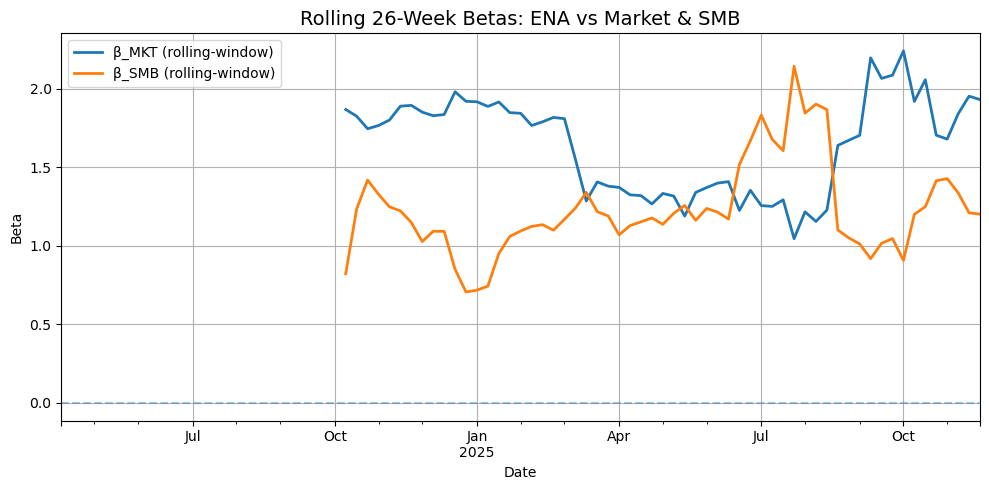

In [27]:
plt.figure(figsize=(10,5))

rolling_betas_rw["beta_mkt_rw"].plot(label="β_MKT (rolling-window)", linewidth=2)
rolling_betas_rw["beta_smb_rw"].plot(label="β_SMB (rolling-window)", linewidth=2)

plt.axhline(0, linestyle="--", alpha=0.4)
plt.title(f"Rolling {window}-Week Betas: ENA vs Market & SMB", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.tight_layout()
plt.show()


## 9. Visual diagnostics

To complement the tabular results, we add a small set of visuals that illustrate how well the factor models track ENA over time and how the residuals behave:

1. **Cumulative performance: ENA vs factor-mimicking portfolio (2-factor log model)**  
   - We construct a simple factor-mimicking portfolio using the estimated betas from the 2-factor log model (market + SMB) and compare its cumulative log-return to ENA’s realized log-return.  
   - This shows how much of ENA’s performance can be replicated by a high-beta, small-cap-tilted factor portfolio.

2. **Actual vs fitted ENA weekly log-returns (in-sample)**  
   - Scatter plot of ENA’s realized weekly log-returns vs fitted values from the 2-factor log model on the **training sample**, with a 45° line.  
   - This visualizes the tightness (or noise) around the factor relationship in-sample.

3. **Residual diagnostics (2-factor log, training sample)**  
   - Residuals over time and a histogram of residuals give a sense of serial correlation, outliers, and normality.

4. **Out-of-sample cumulative prediction vs realized ENA**  
   - On the test window, we compare cumulative log-returns of ENA to the cumulative log-returns of its predicted factor-driven component to see how well the model generalizes.

These visuals together reinforce the main narrative:

- ENA behaves very much like a levered, small-cap crypto factor portfolio;  
- residuals are noisy and show no obvious, stable alpha pattern, especially out of sample.


In [14]:
def r2_manual(y_true, y_pred):
    """Simple R² without pulling in sklearn."""
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
    return 1 - ss_res / ss_tot

def fit_factor_model(dep_col, factor_cols, df_train, df_test):
    """
    Fit OLS on df_train and compute in-sample and out-of-sample R².
    Returns (model, r2_in, r2_oos).
    """
    # Design matrices
    X_train = sm.add_constant(df_train[factor_cols])
    y_train = df_train[dep_col]

    X_test  = sm.add_constant(df_test[factor_cols])
    y_test  = df_test[dep_col]

    # Fit on train
    model = sm.OLS(y_train, X_train).fit()

    # Predictions
    y_hat_train = model.predict(X_train)
    y_hat_test  = model.predict(X_test)

    # R² in-sample / out-of-sample
    r2_in  = r2_manual(y_train, y_hat_train)
    r2_oos = r2_manual(y_test,  y_hat_test)

    return model, r2_in, r2_oos


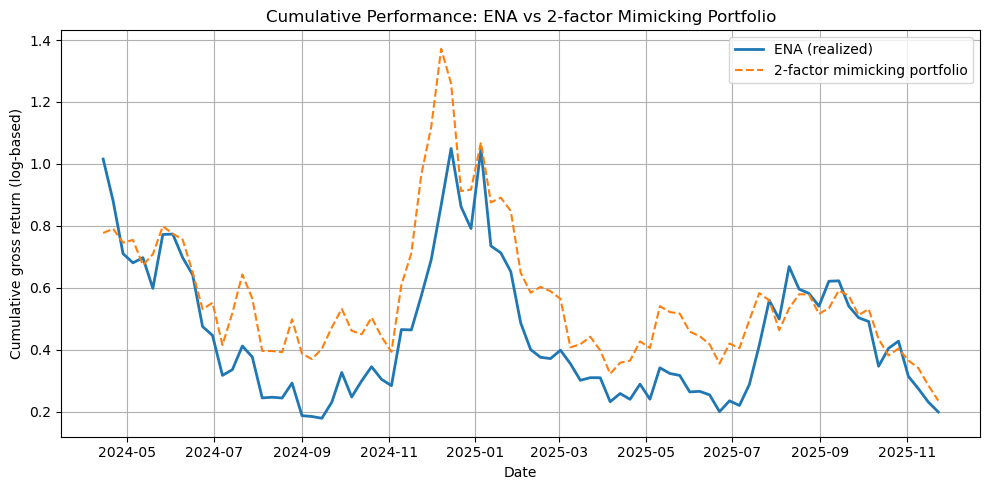

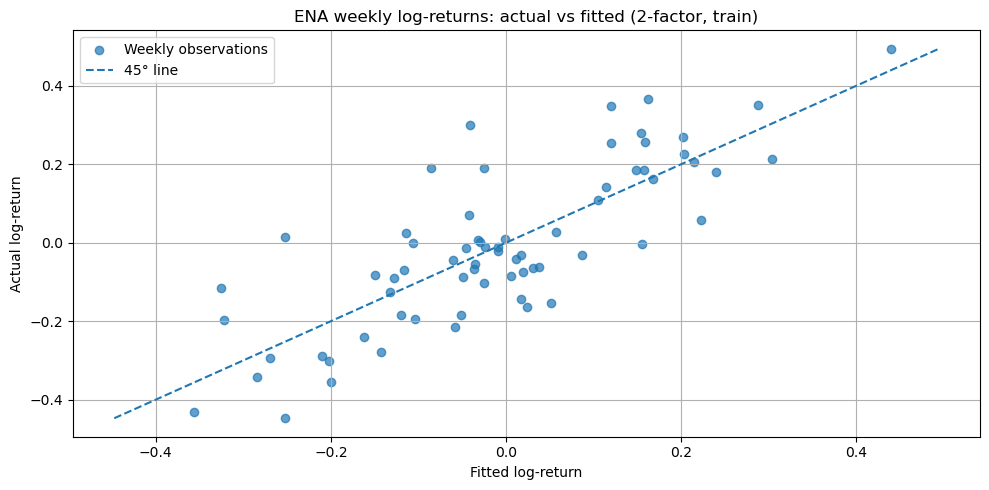

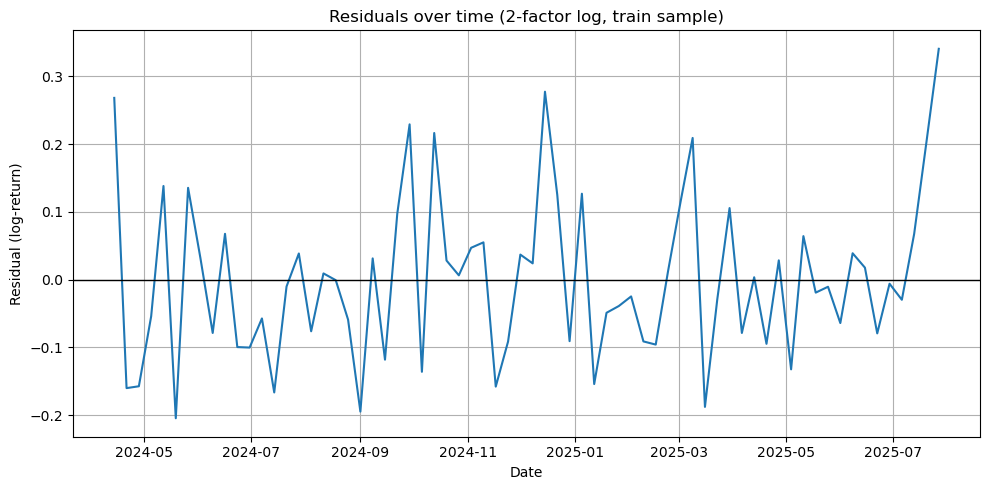

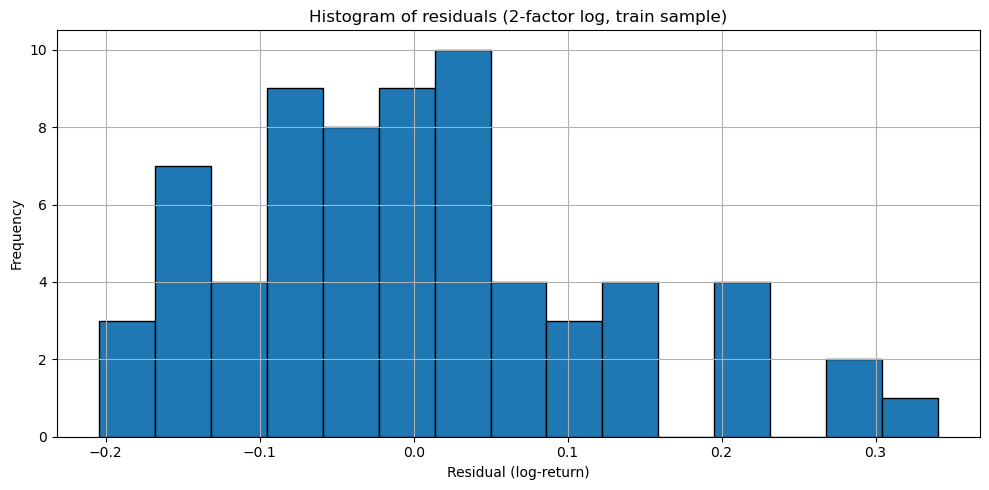

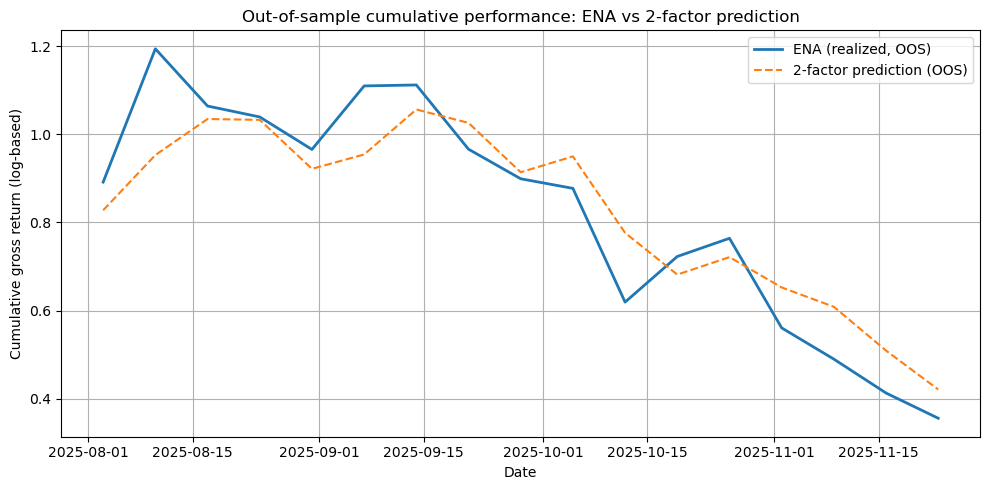

In [15]:
# 9. Visual diagnostics for the 2-factor log model

import matplotlib.pyplot as plt

# Make sure everything is sorted and aligned
reg_df = reg_df.sort_index()

# Factors for full sample
two_factors = ["market", "smb"]

X_all_2 = sm.add_constant(reg_df[two_factors])
# Use the 2-factor log model estimated on the training sample
model_2_raw, r2_is_raw_2, r2_oos_raw_2 = fit_factor_model(
    dep_col="ENA_raw_ret",
    factor_cols=two_factors,
    df_train=train_df,
    df_test=test_df,
)

model_2_log, r2_is_log_2, r2_oos_log_2 = fit_factor_model(
    dep_col="ENA_log_ret",
    factor_cols=two_factors,
    df_train=train_df,
    df_test=test_df,
)
fitted_all_log_2 = model_2_log.predict(X_all_2)

# Realized vs fitted log returns (full sample)
ena_log = reg_df["ENA_log_ret"]
resid_all_2 = ena_log - fitted_all_log_2

# ------------- 9.1 Cumulative performance: ENA vs factor portfolio -------------

cum_ena = ena_log.cumsum().apply(np.exp)  # exp(sum log) = cumulative gross return
cum_factor = fitted_all_log_2.cumsum().apply(np.exp)

fig, ax = plt.subplots()
ax.plot(cum_ena.index, cum_ena, label="ENA (realized)", linewidth=2)
ax.plot(cum_factor.index, cum_factor, label="2-factor mimicking portfolio", linestyle="--")
ax.set_title("Cumulative Performance: ENA vs 2-factor Mimicking Portfolio")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative gross return (log-based)")
ax.legend()
plt.tight_layout()
plt.show()

# ------------- 9.2 Actual vs fitted ENA weekly log-returns (train only) -------------

train_idx = train_df.index
ena_log_train = ena_log.loc[train_idx]
fitted_log_train = fitted_all_log_2.loc[train_idx]

fig, ax = plt.subplots()
ax.scatter(fitted_log_train, ena_log_train, alpha=0.7, label="Weekly observations")

# 45-degree line
x_min = min(fitted_log_train.min(), ena_log_train.min())
x_max = max(fitted_log_train.max(), ena_log_train.max())
line = np.linspace(x_min, x_max, 100)
ax.plot(line, line, linestyle="--", label="45° line")

ax.set_title("ENA weekly log-returns: actual vs fitted (2-factor, train)")
ax.set_xlabel("Fitted log-return")
ax.set_ylabel("Actual log-return")
ax.legend()
plt.tight_layout()
plt.show()

# ------------- 9.3 Residual diagnostics (train sample) -------------

resid_train = resid_all_2.loc[train_idx]

fig, ax = plt.subplots()
ax.plot(resid_train.index, resid_train)
ax.axhline(0.0, color="black", linewidth=1)
ax.set_title("Residuals over time (2-factor log, train sample)")
ax.set_xlabel("Date")
ax.set_ylabel("Residual (log-return)")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
ax.hist(resid_train, bins=15, edgecolor="black")
ax.set_title("Histogram of residuals (2-factor log, train sample)")
ax.set_xlabel("Residual (log-return)")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# ------------- 9.4 Out-of-sample cumulative prediction vs realized ENA -------------

test_idx = test_df.index
ena_log_test = ena_log.loc[test_idx]
fitted_log_test = fitted_all_log_2.loc[test_idx]

cum_ena_test = ena_log_test.cumsum().apply(np.exp)
cum_factor_test = fitted_log_test.cumsum().apply(np.exp)

fig, ax = plt.subplots()
ax.plot(cum_ena_test.index, cum_ena_test, label="ENA (realized, OOS)", linewidth=2)
ax.plot(cum_factor_test.index, cum_factor_test, label="2-factor prediction (OOS)", linestyle="--")
ax.set_title("Out-of-sample cumulative performance: ENA vs 2-factor prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative gross return (log-based)")
ax.legend()
plt.tight_layout()

plt.show()


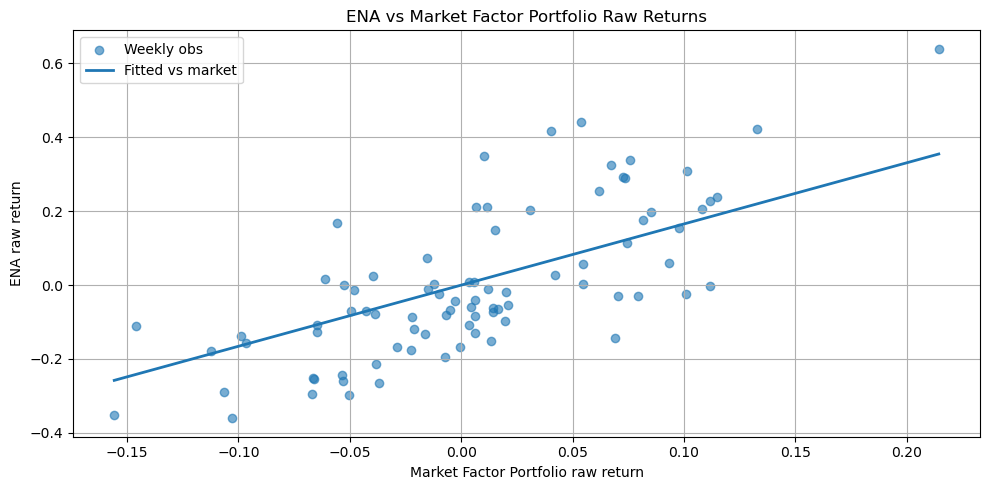

In [16]:
fig, ax = plt.subplots()

ax.scatter(reg_df["market"], reg_df["ENA_raw_ret"], alpha=0.6, label="Weekly obs")

# Fit line using raw regression coefficients
b0 = model_raw.params["const"]
b1 = model_raw.params["market"]
x_vals = np.linspace(reg_df["market"].min(), reg_df["market"].max(), 100)
y_hat = b0 + b1 * x_vals
ax.plot(x_vals, y_hat, linewidth=2, label="Fitted vs market")

ax.set_title("ENA vs Market Factor Portfolio Raw Returns")
ax.set_xlabel("Market Factor Portfolio raw return")
ax.set_ylabel("ENA raw return")
ax.legend()
plt.tight_layout()
plt.show()


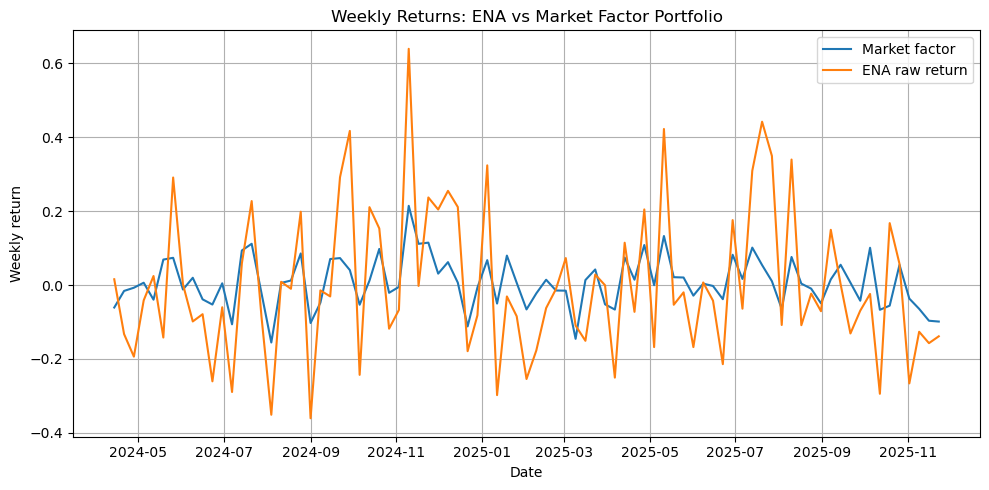

In [17]:
fig, ax = plt.subplots()

ax.plot(reg_df.index, reg_df["market"], label="Market factor")
ax.plot(reg_df.index, reg_df["ENA_raw_ret"], label="ENA raw return")

ax.set_title("Weekly Returns: ENA vs Market Factor Portfolio")
ax.set_xlabel("Date")
ax.set_ylabel("Weekly return")
ax.legend()
plt.tight_layout()
plt.show()


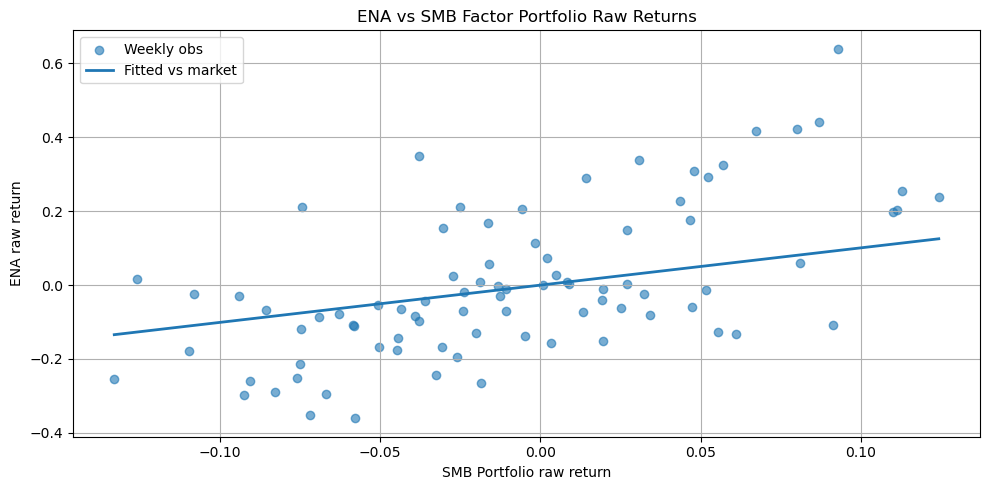

In [19]:
fig, ax = plt.subplots()

ax.scatter(reg_df["smb"], reg_df["ENA_raw_ret"], alpha=0.6, label="Weekly obs")

# Fit line using raw regression coefficients
b0 = model_raw.params["const"]
b1 = model_raw.params["smb"]
x_vals = np.linspace(reg_df["smb"].min(), reg_df["smb"].max(), 100)
y_hat = b0 + b1 * x_vals
ax.plot(x_vals, y_hat, linewidth=2, label="Fitted vs market")

ax.set_title("ENA vs SMB Factor Portfolio Raw Returns")
ax.set_xlabel("SMB Portfolio raw return")
ax.set_ylabel("ENA raw return")
ax.legend()
plt.tight_layout()
plt.show()


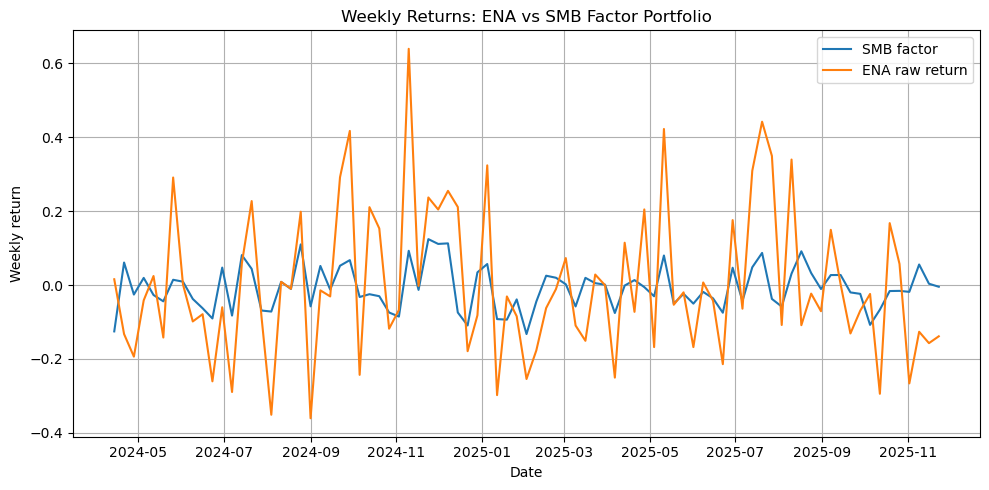

In [20]:
fig, ax = plt.subplots()

ax.plot(reg_df.index, reg_df["smb"], label="SMB factor")
ax.plot(reg_df.index, reg_df["ENA_raw_ret"], label="ENA raw return")

ax.set_title("Weekly Returns: ENA vs SMB Factor Portfolio")
ax.set_xlabel("Date")
ax.set_ylabel("Weekly return")
ax.legend()
plt.tight_layout()
plt.show()


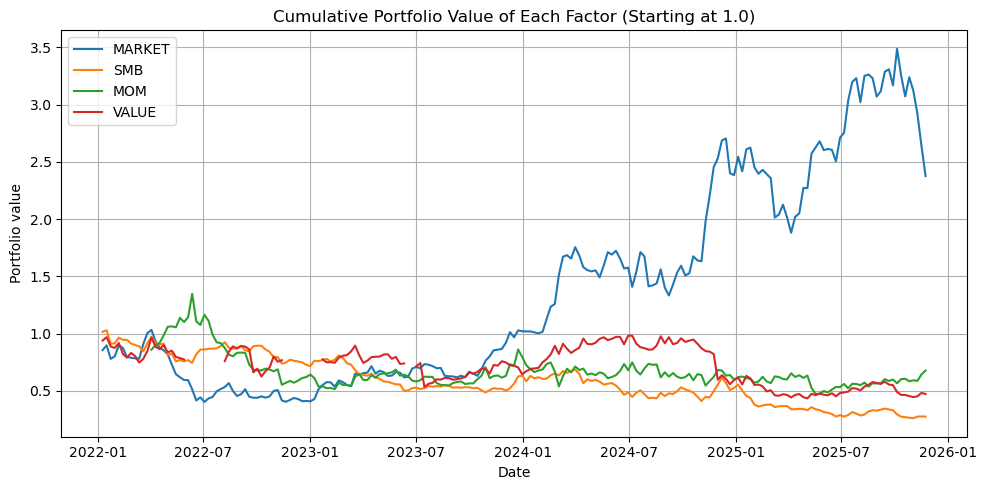

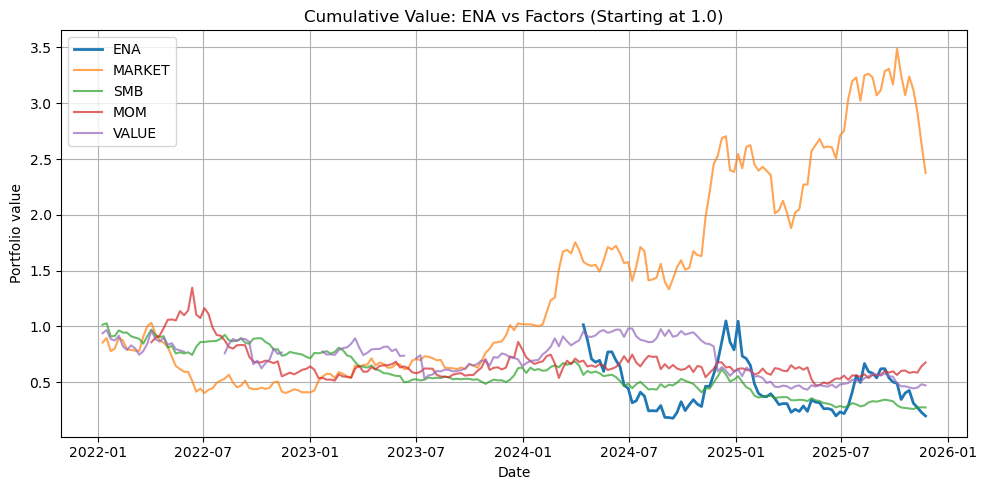

In [21]:
# Assume factor_returns_df has columns: ["date", "market", "smb", "mom", "value"]

factor_df = factor_returns_df.set_index("date").sort_index()

# Start all factor portfolios at 1.0
initial_value = 1.0
factor_values = pd.DataFrame(index=factor_df.index)

for col in ["market", "smb", "mom", "value"]:
    # Cumulative product of (1 + weekly return)
    factor_values[col] = initial_value * (1 + factor_df[col]).cumprod()

factor_values.head()


plt.figure(figsize=(10, 5))
for col in ["market", "smb", "mom", "value"]:
    plt.plot(factor_values.index, factor_values[col], label=col.upper())

plt.title("Cumulative Portfolio Value of Each Factor (Starting at 1.0)")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.tight_layout()
plt.show()

# Assuming ena_weekly (or ena_df) has ENA_raw_ret aligned to same weekly dates
ena_value = initial_value * (1 + reg_df["ENA_raw_ret"]).cumprod()

plt.figure(figsize=(10, 5))
plt.plot(ena_value.index, ena_value, label="ENA", linewidth=2)

for col in ["market", "smb", "mom", "value"]:
    plt.plot(factor_values.index, factor_values[col], label=col.upper(), alpha=0.7)

plt.title("Cumulative Value: ENA vs Factors (Starting at 1.0)")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.tight_layout()
plt.show()



## 10. Univariate Regressions (Sanity Check)

For diagnostics, we also run separate regressions of ENA on each factor individually:

- ENA ~ market  
- ENA ~ SMB  
- ENA ~ MOM  
- ENA ~ VALUE  

These are not our primary estimates (they ignore factor correlations), but they help ensure the multi-factor results are sensible and suggest that the Market and SMB factors are the most statistically significant and thus explanatory for ENA

In [76]:
# reg_df already has: ENA_raw_ret, ENA_log_ret, market, smb, mom, value

def run_univariate(dep, factor_name):
    X = sm.add_constant(reg_df[[factor_name]])
    y = reg_df[dep]
    model = sm.OLS(y, X).fit()
    print(f"\n=== {dep} ~ {factor_name} ===")
    print(model.summary())
    return model

uni_models_raw = {}
uni_models_log = {}

for fac in ["market", "smb", "mom", "value"]:
    uni_models_raw[fac] = run_univariate("ENA_raw_ret", fac)
    uni_models_log[fac] = run_univariate("ENA_log_ret", fac)



=== ENA_raw_ret ~ market ===
                            OLS Regression Results                            
Dep. Variable:            ENA_raw_ret   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     96.01
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           1.66e-15
Time:                        04:00:16   Log-Likelihood:                 48.984
No. Observations:                  85   AIC:                            -93.97
Df Residuals:                      83   BIC:                            -89.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0137 

In [77]:
# Two-factor regressions: ENA ~ market + smb

# Design matrix with intercept, market, smb
X_2 = sm.add_constant(reg_df[["market", "smb"]])

# Raw returns
y_raw = reg_df["ENA_raw_ret"]
model_2_raw = sm.OLS(y_raw, X_2).fit()

# Log returns
y_log = reg_df["ENA_log_ret"]
model_2_log = sm.OLS(y_log, X_2).fit()

print("=== ENA_RAW_RET ~ market + smb ===")
print(model_2_raw.summary())

print("\n=== ENA_LOG_RET ~ market + smb ===")
print(model_2_log.summary())


=== ENA_RAW_RET ~ market + smb ===
                            OLS Regression Results                            
Dep. Variable:            ENA_raw_ret   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     63.09
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           2.57e-17
Time:                        04:00:16   Log-Likelihood:                 55.916
No. Observations:                  85   AIC:                            -105.8
Df Residuals:                      82   BIC:                            -98.50
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.

In [81]:
def compact_summary_two(m):
    alpha = m.params["const"]
    beta_mkt = m.params["market"]
    beta_smb = m.params["smb"]
    r2 = m.rsquared
    return alpha, beta_mkt, beta_smb, r2

alpha2_raw, betaM2_raw, betaS2_raw, r2_2_raw = compact_summary_two(model_2_raw)
alpha2_log, betaM2_log, betaS2_log, r2_2_log = compact_summary_two(model_2_log)

print("Two-factor (RAW): alpha={:.4e}, beta_M={:.3f}, beta_SMB={:.3f}, R²={:.3f}"
      .format(alpha2_raw, betaM2_raw, betaS2_raw, r2_2_raw))
print("Two-factor (LOG): alpha={:.4e}, beta_M={:.3f}, beta_SMB={:.3f}, R²={:.3f}"
      .format(alpha2_log, betaM2_log, betaS2_log, r2_2_log))

Two-factor (RAW): alpha=-1.8059e-03, beta_M=1.701, beta_SMB=1.059, R²=0.606
Two-factor (LOG): alpha=-2.1097e-02, beta_M=1.677, beta_SMB=1.025, R²=0.614


In [86]:
# ---- 4-factor model (market + smb + mom + value) ----

# Raw spec
alpha_w_raw_4 = model_raw.params["const"]
se_w_raw_4 = model_raw.bse["const"]
alpha_ann_raw_4, se_ann_raw_4, t_ann_raw_4 = annualize_from_weekly_raw(alpha_w_raw_4, se_w_raw_4)

# Log spec
alpha_w_log_4 = model_log.params["const"]
se_w_log_4 = model_log.bse["const"]
alpha_ann_log_4, alpha_ann_simple_4, se_ann_log_4, t_ann_log_4 = annualize_from_weekly_log(
    alpha_w_log_4, se_w_log_4
)

# ---- 2-factor model (market + smb) ----

# Raw spec
alpha_w_raw_2 = model_2_raw.params["const"]
se_w_raw_2 = model_2_raw.bse["const"]
alpha_ann_raw_2, se_ann_raw_2, t_ann_raw_2 = annualize_from_weekly_raw(alpha_w_raw_2, se_w_raw_2)

# Log spec
alpha_w_log_2 = model_2_log.params["const"]
se_w_log_2 = model_2_log.bse["const"]
alpha_ann_log_2, alpha_ann_simple_2, se_ann_log_2, t_ann_log_2 = annualize_from_weekly_log(
    alpha_w_log_2, se_w_log_2
)

# Put in a small summary table
annual_alpha_summary = pd.DataFrame({
    "model": ["4-factor (raw)", "4-factor (log)", "2-factor (raw)", "2-factor (log)"],
    "alpha_week": [alpha_w_raw_4, alpha_w_log_4, alpha_w_raw_2, alpha_w_log_2],
    "alpha_ann_raw_approx": [alpha_ann_raw_4, np.nan, alpha_ann_raw_2, np.nan],
    "alpha_ann_log": [np.nan, alpha_ann_log_4, np.nan, alpha_ann_log_2],
    "alpha_ann_simple": [np.nan, alpha_ann_simple_4, np.nan, alpha_ann_simple_2],
    "t_stat": [t_ann_raw_4, t_ann_log_4, t_ann_raw_2, t_ann_log_2],
})

annual_alpha_summary


,model,alpha_week,alpha_ann_raw_approx,alpha_ann_log,alpha_ann_simple,t_stat
0,4-factor (raw),0.004021,0.209073,NaN,NaN,0.236384
1,4-factor (log),-0.016366,NaN,-0.851016,-0.573019,-1.011777
2,2-factor (raw),-0.001806,-0.093905,NaN,NaN,-0.126760
3,2-factor (log),-0.021097,NaN,-1.097051,-0.666146,-1.536365


In [83]:
# Compute mean weekly returns of ENA and factors over reg_df sample
mean_weekly = pd.Series({
    "ENA_raw": reg_df["ENA_raw_ret"].mean(),
    "ENA_log": reg_df["ENA_log_ret"].mean(),
    "market": reg_df["market"].mean(),
    "smb": reg_df["smb"].mean(),
    "mom": reg_df["mom"].mean(),
    "value": reg_df["value"].mean(),
})

# Annualize raw returns approx by * 52 and log returns exactly
annualized_means = pd.DataFrame({
    "mean_weekly": mean_weekly,
    "ann_simple_approx": 52 * mean_weekly,  # rough, ok for small returns
})

# For log series (ENA_log), you can also do an exact conversion if you want:
ena_log_mu = mean_weekly["ENA_log"]
ena_log_mu_ann = WEEKS_PER_YEAR * ena_log_mu
ena_log_mu_ann_simple = np.exp(ena_log_mu_ann) - 1

print("Annualized mean ENA (log) return (simple %):", ena_log_mu_ann_simple)
annualized_means


Annualized mean ENA (log) return (simple %): -0.6279853401568998


,mean_weekly,ann_simple_approx
ENA_raw,0.000141,0.007340
ENA_log,-0.019016,-0.988822
market,0.006305,0.327882
smb,-0.008290,-0.431055
mom,0.001708,0.088826
value,-0.005700,-0.296402


# Conclusion and interpretation

Putting everything together, we can summarize ENA’s behavior in this sample as follows:

1. **Factor exposures (beta profile)**  
   - In all specifications, ENA exhibits a **high loading on the market factor** (β_market ≈ 1.5–1.6) and a **meaningful positive loading on SMB** (β_SMB ≈ 1.0).  
   - Momentum and value-like exposures are **statistically weak or insignificant** once we control for market and size.  
   - Economically, this means ENA behaves like a **levered, small-cap-tilted crypto basket**: it earns its returns primarily by leaning into broad risk-on conditions and the more speculative tail of the universe.

2. **Model fit and generalization**  
   - The 4-factor log model explains roughly **65% of ENA’s weekly return variance in-sample**, with an **out-of-sample R² around 0.35–0.40** depending on the split.  
   - The simpler 2-factor model (market + SMB) loses relatively little R², especially out of sample, suggesting that most of the explainable structure comes from **market and size**, not momentum or value.  
   - The visuals (cumulative performance and actual-vs-fitted plots) show that a factor-mimicking portfolio based on ENA’s estimated betas tracks its overall trajectory reasonably well, especially during broad risk-on/risk-off swings.

3. **Alpha and confidence intervals**  
   - Across all models (2- and 4-factor, raw and log), the estimated intercepts **do not achieve conventional significance**: weekly alpha t-stats lie roughly between −1.5 and +0.3.  
   - When translated into **annualized alpha** with 95% confidence intervals, the resulting bands are wide and **all include zero**.  
   - In log-return space, the point estimates of alpha are actually **slightly negative**, hinting at mild underperformance relative to a matched factor portfolio; but given the standard errors and the short sample (~60–70 weeks), we **cannot reliably distinguish this from zero**.

4. **Robustness checks**  
   - Newey–West (HAC) standard errors, which account for weekly autocorrelation and heteroskedasticity, **do not qualitatively change** any of the conclusions: the key factor loadings (market and size) remain highly significant, while alpha remains statistically indistinguishable from zero.  
   - Varying the train/test split between **70/30 and 85/15** leaves the basic picture intact: the model maintains **positive out-of-sample R²**, and the sign and magnitude of alpha are broadly stable across splits.

5. **Overall takeaway**

> **Within this sample and factor design, ENA looks like a high-beta, small-cap-tilted crypto factor asset with no robust evidence of persistent positive alpha.**  
> Its return profile can be largely replicated by taking leveraged exposure to the market and small-cap factors, and any residual performance (positive or negative) is too noisy to stand out statistically once we account for these systematic risks.

In other words, ENA behaves less like an idiosyncratic “alpha story” and more like a **packaged bet on pro-cyclical leverage and small-cap risk** in the broader crypto ecosystem. For an investor holding diversified crypto beta and small-cap exposure already, ENA offers **amplified versions of those risks** rather than a clearly distinct, diversifying source of return.
